# Import em1d

In [2]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

import em1d as zpic
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML
import os
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Set up the amplitudes

Number of waves = 25


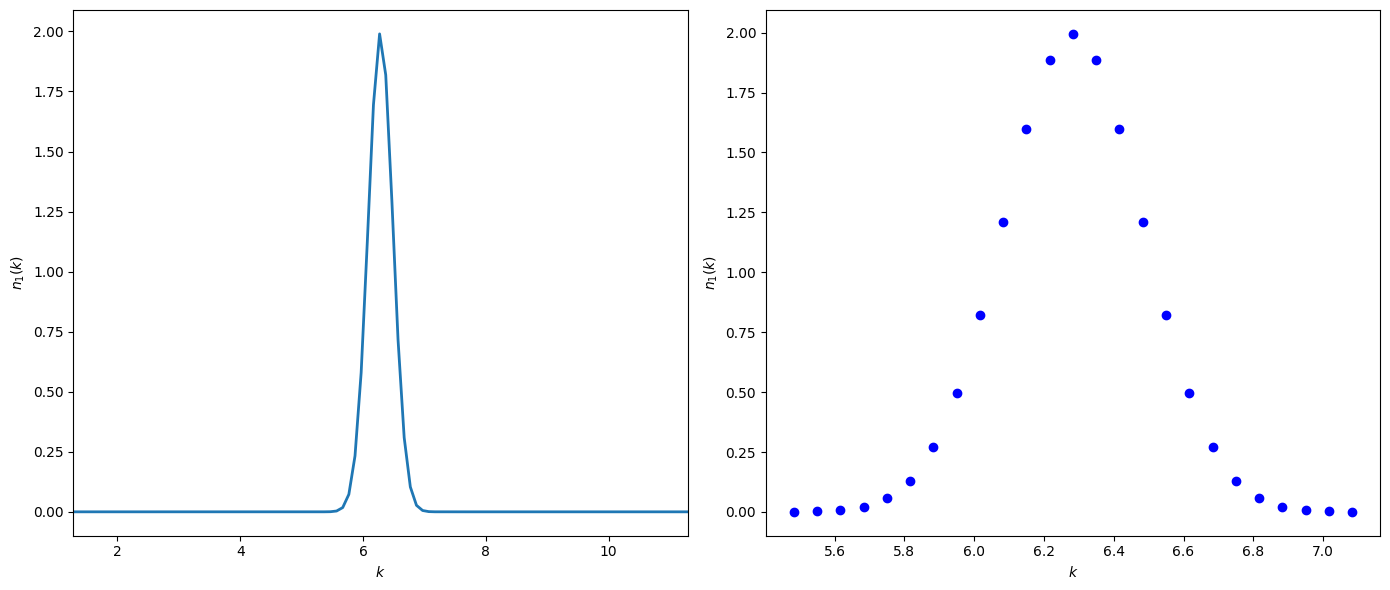

In [3]:
nx = 5000   # Number of cells in the x direction
box = 100   # Size of the box
dx = box / nx

dt_courant = 1 / np.sqrt(1.0/dx**2)

# Set dt/dx = 0.5

dt = 0.99 * dx

ppc = 5000 # Particles per cell


# Initialize the velocities before the simulation
exp = 4
vth = 10**-exp
#vth = 0
uth = [vth,vth,vth] # Initial thermal velocity
ufl = [0.0,0.0,0.0] # Initial fluid velocity

# Dispersion relation
omega_p = 1.0

def omega(x):
    return np.sqrt(1.0 + (1.5*x**2*uth[0]**2)/omega_p**2)


# Wave parameters
k_0 = 2*np.pi
sigma_k = 0.2

Delta_x = box
Delta_k = 2*np.pi/Delta_x
k_f = k_0+4.0*sigma_k
k_i = k_0-4.0*sigma_k
n_waves = int((k_f-k_i)/Delta_k)
print(f"Number of waves = {n_waves}")
k_values = np.linspace(k_i, k_f, n_waves)
k_values = k_values[k_values > 0]  # Filter out negative values

# Amplitude of the n1 wave
def n1_w(k): # n1 = A*exp[-alpha*(k-k0)^2]
    A = 1 / (np.sqrt(2*np.pi*sigma_k**2))
    alpha = 1 / (2*sigma_k**2)
    return A * np.exp(-alpha*(k-k_0)**2)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot n1(k) vs k
k_array = np.linspace(Delta_k, 100+Delta_k, 1000)
ax1.plot(k_array, n1_w(k_array), lw=2)
ax1.set_xlim(k_0-5, k_0+5)
ax1.set_xlabel(r'$k$')
ax1.set_ylabel(r'$n_1(k)$')

# Scatter plot of n1
ax2.scatter(k_values, n1_w(k_values), color='b')
ax2.set_xlabel(r'$k$')
ax2.set_ylabel(r'$n_1(k)$')

plt.tight_layout()
plt.show()


# Define the density profile and the Electric field

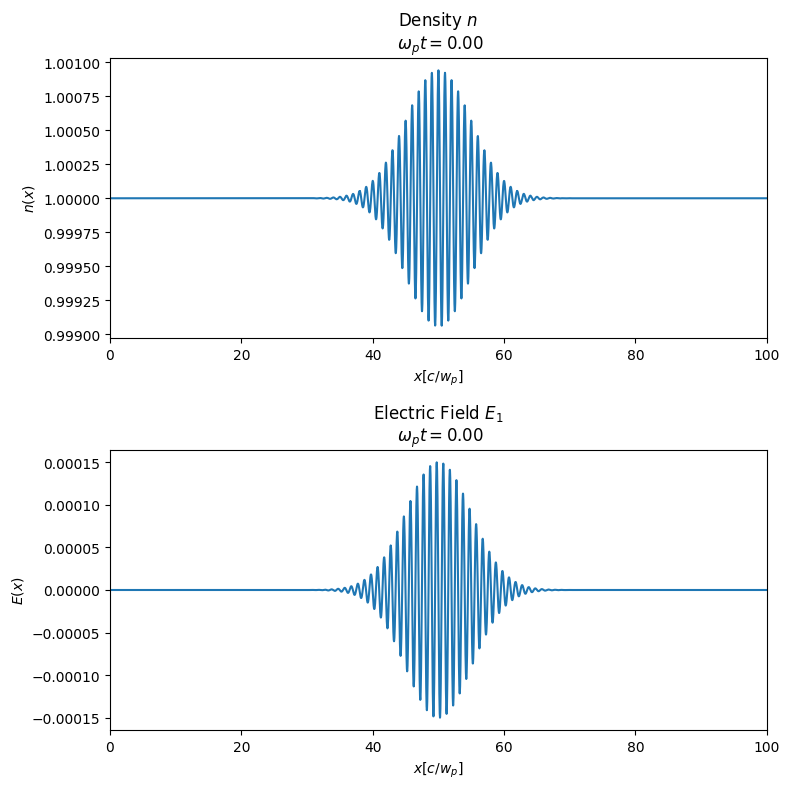

In [4]:
# Density profile
n0 = 1
def custom_n(x):
    wave_sum = 0
    for k in k_values:
        wave_sum += n1_w(k)*np.cos(k*(x-box/2))
        #wave_sum += n1_w(k)*np.cos(k*x)
    wave_sum *= Delta_k/1000 # Scaled by a factor of 1000
    return n0 + wave_sum

density = zpic.Density( type = "custom", custom = custom_n )


# Background plasma
electrons = zpic.Species("electrons", -1.0, ppc, density=density, uth=uth, ufl=ufl, bc_type="periodic")
sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )

electrons.n_sort = 0

# Magnetic field
#B_ext = zpic.InitialField(B_type = 'none')
#
#sim.emf.init_fld( B_ext )


#Electric field
def E1_field( ix, dx ):
    # Ex is located at the center of the cell
    x = (ix+0.5)*dx
    wave_sum_E = 0
    for k in k_values:
        wave_sum_E += -(n1_w(k))/k*np.sin(k*(x-box/2) - omega(k)*sim.t)
        #wave_sum_E += -(n1_w(k))/k*np.sin(k*x - omega(k)*sim.t)
    wave_sum_E *= Delta_k/1000 # Scaled by a factor of 1000
    return [wave_sum_E,0,0]

E_ext = zpic.InitialField(E_type = 'custom', E_custom = E1_field )

sim.emf.init_fld( E_ext )


# Plot the initial field values at the center of the cells
xmin = 0
xmax = sim.box
x_values = np.linspace(xmin, xmax, num=sim.nx)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

ax1.plot(x_values, np.abs(electrons.charge()))
ax1.set_xlabel(r"$x [c/w_p]$")
ax1.set_xlim((0, box))
ax1.set_ylabel(r"$n(x)$")
ax1.set_title(f"Density $n$\n $\omega_pt = {sim.t:.2f}$")

ax2.plot(x_values, sim.emf.Ex)
ax2.set_xlabel(r"$x [c/w_p]$")
ax2.set_xlim((0, box))
ax2.set_ylabel(r"$E(x)$")
ax2.set_title(f"Electric Field $E_1$\n $\omega_pt = {sim.t:.2f}$")

plt.tight_layout()
plt.show()


# Update the velocities after the simulation is created and before advancing the time step

In [5]:
print()
print(electrons.particles)

def v1(x):
    wave_sum_v = 0
    for k in k_values:
        wave_sum_v += (omega(k)/k)*n1_w(k)*np.cos(k*(x-box/2))
        #wave_sum_v += (omega(k)/k)*n1_w(k)*np.cos(k*x)
    wave_sum_v *= Delta_k/1000 # Scaled by a factor of 1000
    return wave_sum_v

for particle in electrons.particles:
    pos = (particle['ix'] + particle['x']) * sim.dx
    particle['ux'] += v1(pos)

print()
print(electrons.particles)



[(   0, 9.9999997e-05,  3.3632165e-05,  1.41547207e-04,  1.4694352e-06)
 (   0, 3.0000001e-04, -2.5054440e-05,  7.59976729e-06, -2.2140892e-05)
 (   0, 5.0000002e-04, -3.0853719e-04,  2.04241514e-05, -2.6675050e-05)
 ...
 (4999, 9.9950033e-01,  7.1413102e-05, -1.05494204e-04,  2.2203624e-04)
 (4999, 9.9970037e-01,  2.4867739e-05, -2.31685081e-05,  1.7902380e-04)
 (4999, 9.9990034e-01, -6.1357357e-05, -3.06388742e-04,  7.9020843e-05)]

[(   0, 9.9999997e-05,  3.3630015e-05,  1.41547207e-04,  1.4694352e-06)
 (   0, 3.0000001e-04, -2.5056590e-05,  7.59976729e-06, -2.2140892e-05)
 (   0, 5.0000002e-04, -3.0853934e-04,  2.04241514e-05, -2.6675050e-05)
 ...
 (4999, 9.9950033e-01,  7.1410948e-05, -1.05494204e-04,  2.2203624e-04)
 (4999, 9.9970037e-01,  2.4865589e-05, -2.31685081e-05,  1.7902380e-04)
 (4999, 9.9990034e-01, -6.1359511e-05, -3.06388742e-04,  7.9020843e-05)]


# Compare J_theory vs J_simulation at $w_pt = 0$

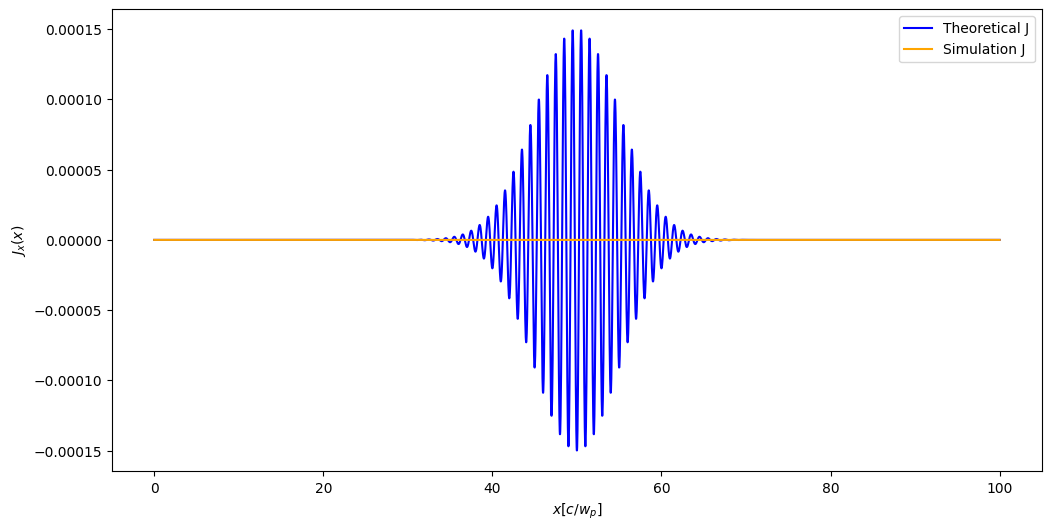

In [6]:
def v1_xt(x):
    wave_sum_v = 0
    for k in k_values:
        wave_sum_v += (omega(k)/k)*n1_w(k)*np.cos(k*(x-box/2)-omega(k)*sim.t)
    wave_sum_v *= Delta_k/1000 # Scaled by a factor of 1000
    return wave_sum_v

def J_theory(x):
    return - n0*v1_xt(x)

plt.figure(figsize=(12, 6))

plt.plot(x_values, J_theory(x_values), color='b', label='Theoretical J')
plt.plot(x_values, sim.current.Jx, color='orange', label='Simulation J')
plt.xlabel(r"$x [c/w_p]$")
plt.ylabel(r"$J_x(x)$")
plt.legend()
plt.show()



# Run the simulation and check how n and E evolve


Running simulation up to t = 49.995 ...
n = 2524, t = 49.9752
Done.


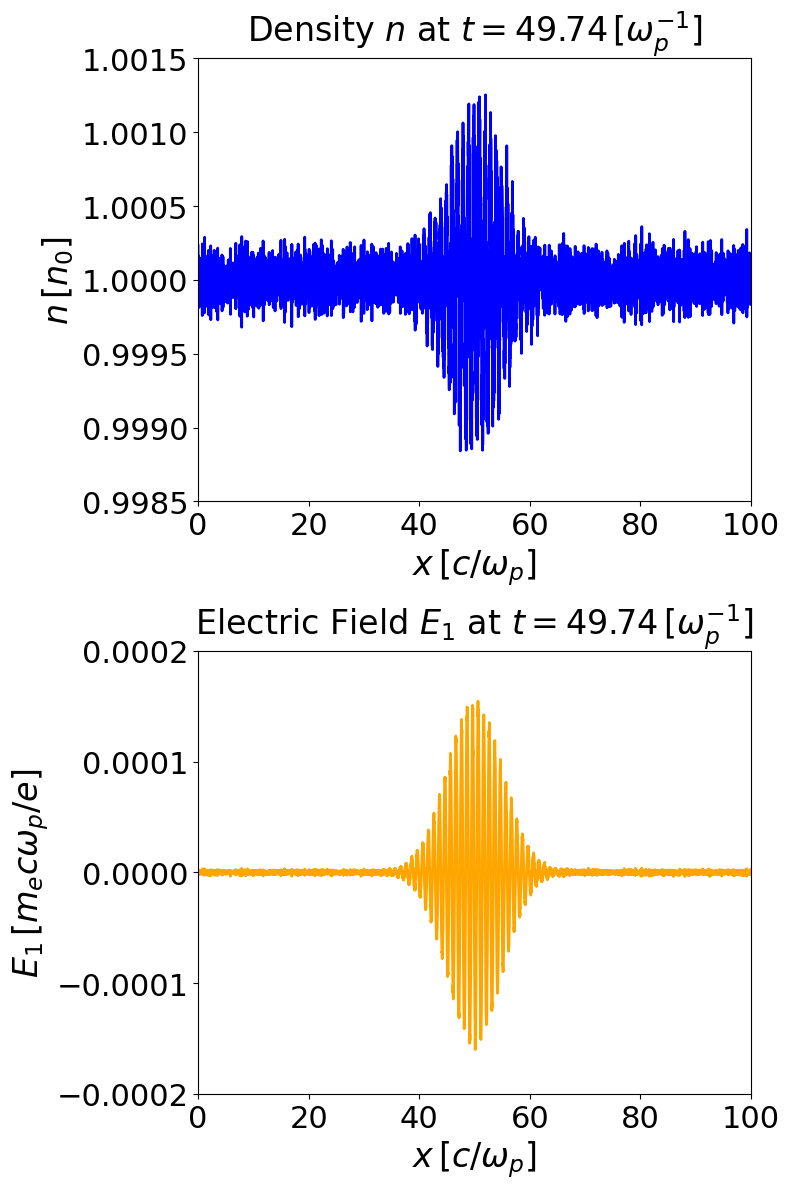

In [7]:
#tmax = 500

tmax = 50
t2_range = [2-sim.dt/2, 2+sim.dt/2]
t6_range = [6-sim.dt/2, 6+sim.dt/2]
t10_range = [10-sim.dt/2, 10+sim.dt/2]
t20_range = [20-sim.dt/2, 20+sim.dt/2]
t30_range = [30-sim.dt/2, 30+sim.dt/2]
t40_range = [40-sim.dt/2, 40+sim.dt/2]
t100_range = [100-sim.dt/2, 100+sim.dt/2]
t200_range = [200-sim.dt/2, 200+sim.dt/2]
t300_range = [300-sim.dt/2, 300+sim.dt/2]

#print("initial")
#print(electrons.particles[0])
#kinetic_energy = 0
#for particle in electrons.particles:
#    kinetic_energy += 0.5*(particle['ux'])**2
#print(f"Initial kinetic energy = {kinetic_energy}")

# Run the simulation

''' We run the simulation up to a fixed number of iterations, controlled by the variable `niter`,
storing the values of n and E at every timestep so we can analyze them later. '''
niter = int(tmax / sim.dt)
Ex_t = np.zeros((niter,sim.nx))
n_t = np.zeros((niter,sim.nx))

print("\nRunning simulation up to t = {:g} ...".format(niter * sim.dt))
while sim.n < niter:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    Ex_t[sim.n,:] = sim.emf.Ex
    n_t[sim.n,:] =  np.abs(electrons.charge())
    sim.iter()

    ## J_theory vs J_sim
    #if sim.t >= t2_range[0] and sim.t <= t2_range[1]:
    #    plt.figure(figsize=(12, 6))
    #    plt.plot(x_values, J_theory(x_values), color='b', label='Theoretical J')
    #    plt.plot(x_values, sim.current.Jx, color='orange', label='Simulation J')
    #    plt.xlabel(r"$x [c/w_p]$")
    #    plt.ylabel(r"$J_x(x)$")
    #    plt.legend()
    #    plt.title(f"Current at $\omega_pt = {sim.t:.2f}$")
    #    plt.show()
    #    print(electrons.particles[0])
    #    kinetic_energy = 0
    #    for particle in electrons.particles:
    #        kinetic_energy += 0.5*(particle['ux'])**2
    #    print(f"Kinetic energy = {kinetic_energy}")
    #
    #if sim.t >= t6_range[0] and sim.t <= t6_range[1]:
    #    plt.figure(figsize=(12, 6))
    #    plt.plot(x_values, J_theory(x_values), color='b', label='Theoretical J')
    #    plt.plot(x_values, sim.current.Jx, color='orange', label='Simulation J')
    #    plt.xlabel(r"$x [c/w_p]$")
    #    plt.ylabel(r"$J_x(x)$")
    #    plt.legend()
    #    plt.title(f"Current at $\omega_pt = {sim.t:.2f}$")
    #    plt.show()
    #    print(electrons.particles[0])
    #    kinetic_energy = 0
    #    for particle in electrons.particles:
    #        kinetic_energy += 0.5*(particle['ux'])**2
    #    print(f"Kinetic energy = {kinetic_energy}")
#
    #if sim.t >= t10_range[0] and sim.t <= t10_range[1]:
    #    plt.figure(figsize=(12, 6))
    #    plt.plot(x_values, J_theory(x_values), color='b', label='Theoretical J')
    #    plt.plot(x_values, sim.current.Jx, color='orange', label='Simulation J')
    #    plt.xlabel(r"$x [c/w_p]$")
    #    plt.ylabel(r"$J_x(x)$")
    #    plt.legend()
    #    plt.title(f"Current at $\omega_pt = {sim.t:.2f}$")
    #    plt.show()
    #    print(electrons.particles[0])
    #    kinetic_energy = 0
    #    for particle in electrons.particles:
    #        kinetic_energy += 0.5*(particle['ux'])**2
    #    print(f"Kinetic energy = {kinetic_energy}")
    #
    #if sim.t >= t20_range[0] and sim.t <= t20_range[1]:
    #    plt.figure(figsize=(12, 6))
    #    plt.plot(x_values, J_theory(x_values), color='b', label='Theoretical J')
    #    plt.plot(x_values, sim.current.Jx, color='orange', label='Simulation J')
    #    plt.xlabel(r"$x [c/w_p]$")
    #    plt.ylabel(r"$J_x(x)$")
    #    plt.legend()
    #    plt.title(f"Current at $\omega_pt = {sim.t:.2f}$")
    #    plt.show()
    #    print(electrons.particles[0])
    #    kinetic_energy = 0
    #    for particle in electrons.particles:
    #        kinetic_energy += 0.5*(particle['ux'])**2
    #    print(f"Kinetic energy = {kinetic_energy}")
#
    #if sim.t >= t30_range[0] and sim.t <= t30_range[1]:
    #    plt.figure(figsize=(12, 6))
    #    plt.plot(x_values, J_theory(x_values), color='b', label='Theoretical J')
    #    plt.plot(x_values, sim.current.Jx, color='orange', label='Simulation J')
    #    plt.xlabel(r"$x [c/w_p]$")
    #    plt.ylabel(r"$J_x(x)$")
    #    plt.legend()
    #    plt.title(f"Current at $\omega_pt = {sim.t:.2f}$")
    #    plt.show()
    #    print(electrons.particles[0])
    #    kinetic_energy = 0
    #    for particle in electrons.particles:
    #        kinetic_energy += 0.5*(particle['ux'])**2
    #    print(f"Kinetic energy = {kinetic_energy}")
#
    #if sim.t >= t40_range[0] and sim.t <= t40_range[1]:
    #    plt.figure(figsize=(12, 6))
    #    plt.plot(x_values, J_theory(x_values), color='b', label='Theoretical J')
    #    plt.plot(x_values, sim.current.Jx, color='orange', label='Simulation J')
    #    plt.xlabel(r"$x [c/w_p]$")
    #    plt.ylabel(r"$J_x(x)$")
    #    plt.legend()
    #    plt.title(f"Current at $\omega_pt = {sim.t:.2f}$")
    #    plt.show()
    #    print(electrons.particles[0])
    #    kinetic_energy = 0
    #    for particle in electrons.particles:
    #        kinetic_energy += 0.5*(particle['ux'])**2
    #    print(f"Kinetic energy = {kinetic_energy}")
#
    #if sim.t >= t100_range[0] and sim.t <= t100_range[1]:
    #    plt.figure(figsize=(12, 6))
    #    plt.plot(x_values, J_theory(x_values), color='b', label='Theoretical J')
    #    plt.plot(x_values, sim.current.Jx, color='orange', label='Simulation J')
    #    plt.xlabel(r"$x [c/w_p]$")
    #    plt.ylabel(r"$J_x(x)$")
    #    plt.legend()
    #    plt.title(f"Current at $\omega_pt = {sim.t:.2f}$")
    #    plt.show()
    #    print(electrons.particles[0])
    #    kinetic_energy = 0
    #    for particle in electrons.particles:
    #        kinetic_energy += 0.5*(particle['ux'])**2
    #    print(f"Kinetic energy = {kinetic_energy}")
#
    #if sim.t >= t200_range[0] and sim.t <= t200_range[1]:
    #    plt.figure(figsize=(12, 6))
    #    plt.plot(x_values, J_theory(x_values), color='b', label='Theoretical J')
    #    plt.plot(x_values, sim.current.Jx, color='orange', label='Simulation J')
    #    plt.xlabel(r"$x [c/w_p]$")
    #    plt.ylabel(r"$J_x(x)$")
    #    plt.legend()
    #    plt.title(f"Current at $\omega_pt = {sim.t:.2f}$")
    #    plt.show()
    #    print(electrons.particles[0])
    #    kinetic_energy = 0
    #    for particle in electrons.particles:
    #        kinetic_energy += 0.5*(particle['ux'])**2
    #    print(f"Kinetic energy = {kinetic_energy}")
#
    #if sim.t >= t300_range[0] and sim.t <= t300_range[1]:
    #    plt.figure(figsize=(12, 6))
    #    plt.plot(x_values, J_theory(x_values), color='b', label='Theoretical J')
    #    plt.plot(x_values, sim.current.Jx, color='orange', label='Simulation J')
    #    plt.xlabel(r"$x [c/w_p]$")
    #    plt.ylabel(r"$J_x(x)$")
    #    plt.legend()
    #    plt.title(f"Current at $\omega_pt = {sim.t:.2f}$")
    #    plt.show()
    #    print(electrons.particles[0])
    #    kinetic_energy = 0
    #    for particle in electrons.particles:
    #        kinetic_energy += 0.5*(particle['ux'])**2
    #    print(f"Kinetic energy = {kinetic_energy}")

print("\nDone.")

# Movie parameters
nframes = 200
fps = 16

# Increase the embed limit if the movie is large
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 128

# Create plots
x_vals = np.linspace(0, sim.box, sim.nx)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
ax1.set_xlim((0, sim.box))
ax1.set_ylim((0.9985, 1.0015))
ax2.set_xlim((0, sim.box))
ax2.set_ylim((-0.00020, 0.00020))


line1, = ax1.plot([], [], lw=2, color='blue')
line2, = ax2.plot([], [], lw=2, color='orange')

ax1.set_xlabel(r"$x \,[c/\omega_p]$", fontsize=24)
ax1.set_ylabel(r"$n \,[n_0]$", fontsize=24)

ax2.set_xlabel(r"$x \,[c/\omega_p]$", fontsize=24)
ax2.set_ylabel(r"$E_1 \,[m_ec\omega_p/e]$", fontsize=24)

for ax in ax1, ax2:
    ax.tick_params(axis='both', which='major', labelsize=22)


# Animation function
def animate(i):
    time_index = int(i * len(Ex_t) / nframes)  # Map frame to time index in Ex_t and n_t
    line1.set_data(x_vals, n_t[time_index, :])
    line2.set_data(x_vals, Ex_t[time_index, :])

    # Compute time based on simulation step and time step
    current_time = time_index * sim.dt  

    ax1.set_title(f"Density $n$ at $t = {current_time:.2f} \, [\omega_p^{{-1}}]$", fontsize=24)
    ax2.set_title(f"Electric Field $E_1$ at $ t = {current_time:.2f} \, [\omega_p^{{-1}}]$", fontsize=24)

    plt.tight_layout()  # Adjust layout dynamically to prevent overlap

    return (line1, line2)


## Create the movie
#anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=False, blit=True, interval=1000.0 / fps)
#
## Show the completed movie
#plt.close()
#HTML(anim.to_html5_video())

output_folder = "simulation_videos"
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
#output_path = os.path.join(output_folder, f"wavepacket_vth=10^-{exp}_tmax={tmax}_box={box}_nx={nx}_ppc={ppc}_dt=0.99dx_sem(x).mp4")
output_path = os.path.join(output_folder, f"aa_slide_GoLP2.mp4")

# Save the animation
writer = FFMpegWriter(fps=fps, metadata={"title": "Simulation", "artist": "YourName"})
with writer.saving(fig, output_path, dpi=100):
    for i in range(int(nframes)):
        animate(i)  # Update frame
        writer.grab_frame()


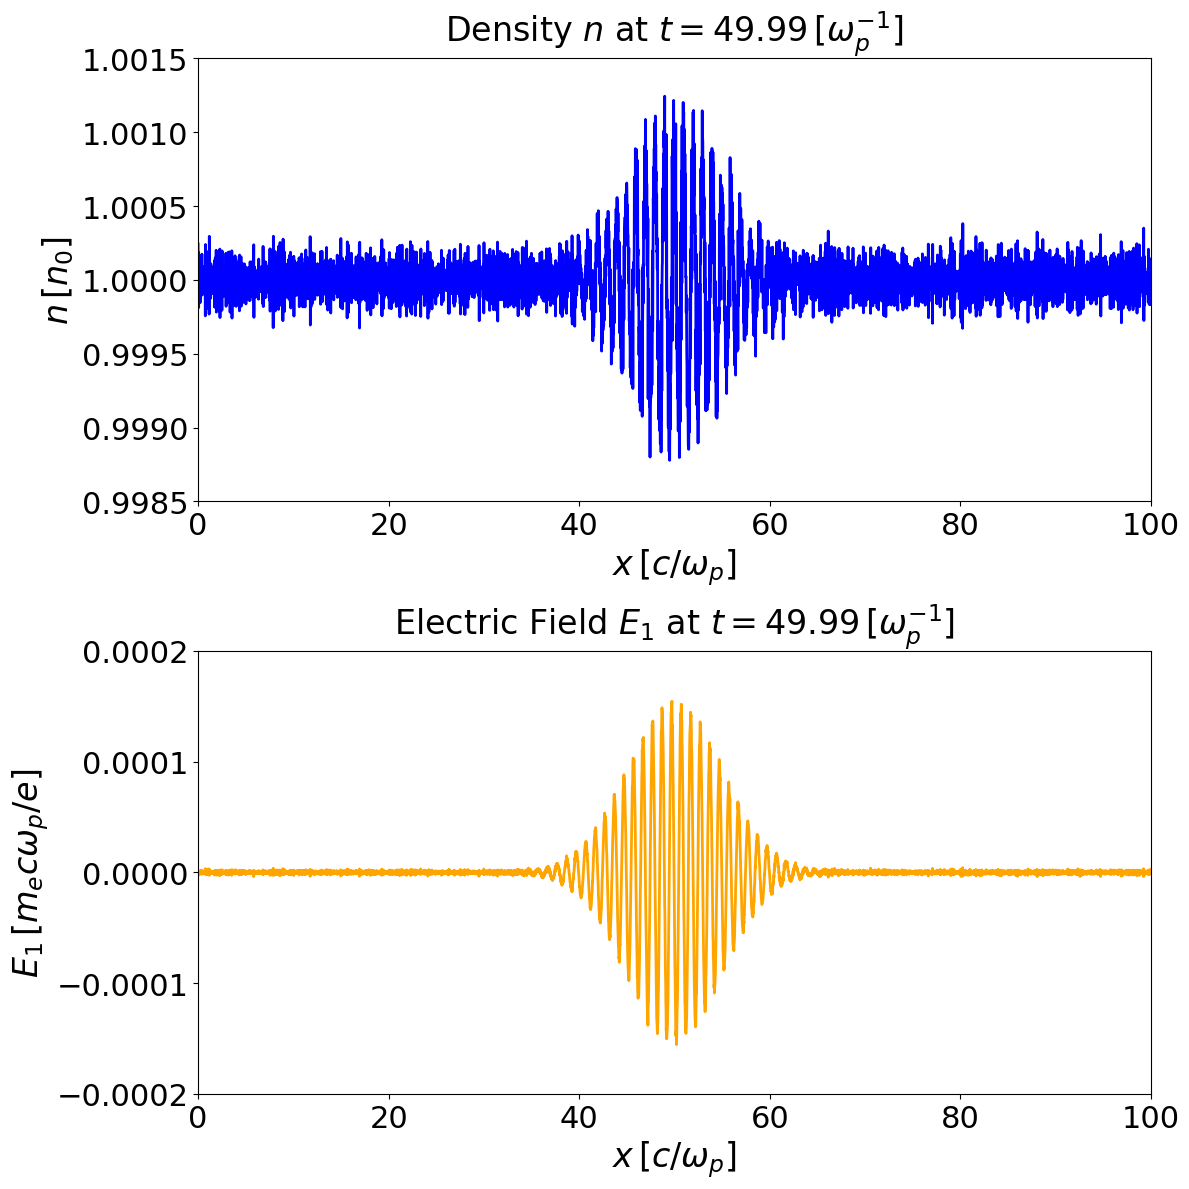

In [8]:
# After running the simulation loop:
last_index = niter - 1  # Last frame index

# Create a figure for the final frame
x_vals = np.linspace(0, sim.box, sim.nx)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot the final density profile
ax1.plot(x_vals, n_t[last_index, :], lw=2, color='blue')
ax1.set_xlim(0, sim.box)
ax1.set_ylim((0.9985, 1.0015))
ax1.set_xlabel(r"$x \,[c/\omega_p]$", fontsize=24)
ax1.set_ylabel(r"$n \,[n_0]$", fontsize=24)
ax1.set_title(f"Density $n$ at $t = {sim.t:.2f} \, [\omega_p^{{-1}}]$", fontsize=24)

# Plot the final electric field profile
ax2.plot(x_vals, Ex_t[last_index, :], lw=2, color='orange')
ax2.set_xlim(0, sim.box)
ax2.set_ylim((-0.00020, 0.00020))
ax2.set_xlabel(r"$x \,[c/\omega_p]$", fontsize=24)
ax2.set_ylabel(r"$E_1 \,[m_ec\omega_p/e]$", fontsize=24)
ax2.set_title(f"Electric Field $E_1$ at $ t = {sim.t:.2f} \, [\omega_p^{{-1}}]$", fontsize=24)

for ax in ax1, ax2:
    ax.tick_params(axis='both', which='major', labelsize=22)

plt.tight_layout()
plt.savefig("last_frame_sem(x).pdf", format="pdf")
plt.show()


# Phase space evolution

In [9]:
#nx = 5000   # Number of cells in the x direction
#box = 100   # Size of the box
#dx = box / nx
#
#dt_courant = 1 / np.sqrt(1.0/dx**2)
#
## Set dt/dx = 0.5
#
#dt = 0.99 * dx
#
#ppc = 500 # Particles per cell
#
#
## Initialize the velocities before the simulation
#uth = [0.0,0.0,0.0] # Initial thermal velocity
#ufl = [0.0,0.0,0.0] # Initial fluid velocity
#
## Dispersion relation
#omega_p = 1.0
#
#def omega(x):
#    return np.sqrt(1.0 + (1.5*x**2*uth[0]**2)/omega_p**2)
#
#
## Wave parameters
#k_0 = 2*np.pi
#sigma_k = 0.2
#
#Delta_x = box
#Delta_k = 2*np.pi/Delta_x
#k_f = k_0+4.0*sigma_k
#k_i = k_0-4.0*sigma_k
#n_waves = int((k_f-k_i)/Delta_k)
#k_values = np.linspace(k_i, k_f, n_waves)
#k_values = k_values[k_values > 0]  # Filter out negative values
#
## Amplitude of the n1 wave
#def n1_w(k): # n1 = A*exp[-alpha*(k-k0)^2]
#    A = 1 / (np.sqrt(2*np.pi*sigma_k**2))
#    alpha = 1 / (2*sigma_k**2)
#    return A * np.exp(-alpha*(k-k_0)**2)
#
## Density profile
#n0 = 1
#def custom_n(x):
#    wave_sum = 0
#    for k in k_values:
#        wave_sum += n1_w(k)*np.cos(k*(x-box/2))
#        #wave_sum += n1_w(k)*np.cos(k*x)
#    wave_sum *= Delta_k/1000 # Scaled by a factor of 1000
#    return n0 + wave_sum
#
#density = zpic.Density( type = "custom", custom = custom_n )
#
#
## Background plasma
#electrons = zpic.Species("electrons", -1.0, ppc, density=density, uth=uth, ufl=ufl, bc_type="periodic")
#sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )
#
#electrons.n_sort = 0
#
##Electric field
#def E1_field( ix, dx ):
#    # Ex is located at the center of the cell
#    x = (ix+0.5)*dx
#    wave_sum_E = 0
#    for k in k_values:
#        wave_sum_E += -(n1_w(k))/k*np.sin(k*(x-box/2) - omega(k)*sim.t)
#        #wave_sum_E += -(n1_w(k))/k*np.sin(k*x - omega(k)*sim.t)
#    wave_sum_E *= Delta_k/1000 # Scaled by a factor of 1000
#    return [wave_sum_E,0,0]
#
#E_ext = zpic.InitialField(E_type = 'custom', E_custom = E1_field )
#
#sim.emf.init_fld( E_ext )
#
#def v1(x):
#    wave_sum_v = 0
#    for k in k_values:
#        wave_sum_v += (omega(k)/k)*n1_w(k)*np.cos(k*(x-box/2))
#        #wave_sum_v += (omega(k)/k)*n1_w(k)*np.cos(k*x)
#    wave_sum_v *= Delta_k/1000 # Scaled by a factor of 1000
#    return wave_sum_v
#
#for particle in electrons.particles:
#    pos = (particle['ix'] + particle['x']) * sim.dx
#    particle['ux'] = v1(pos)
#
########################################################################################################################
#tmax = 1000
#
#vmax = np.max(np.abs(electrons.particles['ux']))
#print(vmax)
#
#def v1_theory(x):
#    wave_sum_v = 0
#    for k in k_values:
#        wave_sum_v += (omega(k)/k)*n1_w(k)*np.cos(k*(x-box/2)-omega(k)*sim.t)
#    wave_sum_v *= Delta_k/1000 # Scaled by a factor of 1000
#    return wave_sum_v
#
#x_vals = np.linspace(0, sim.box, sim.nx)
#
## Run the simulation
#
#''' We run the simulation up to a fixed number of iterations, controlled by the variable `niter`,
#storing the values of n and E at every timestep so we can analyze them later. '''
#niter = int(tmax / sim.dt)
#save_interval = 40  # Save every 40 iterations to reduce memory usage
#saved_steps = (niter // save_interval) + 1  # Fix index out-of-bounds error
#
#x_vals = np.linspace(0, sim.box, sim.nx)
#
#Ex_t = np.zeros((saved_steps, sim.nx))
#n_t = np.zeros((saved_steps, sim.nx))
#v_theory_t = np.zeros((saved_steps, sim.nx))
#particle_x_t = np.zeros((saved_steps, electrons.particles.shape[0]))
#particle_ux_t = np.zeros((saved_steps, electrons.particles.shape[0]))
#
#print("\nRunning simulation up to t = {:g} ...".format(niter * sim.dt))
#saved_index = 0
#while sim.n < niter:
#    if sim.n % save_interval == 0 and saved_index < saved_steps:
#        Ex_t[saved_index, :] = sim.emf.Ex
#        n_t[saved_index, :] = np.abs(electrons.charge())
#        v_theory_t[saved_index, :] = v1_theory(x_vals)
#        particle_x_t[saved_index, :] = (electrons.particles['ix'] + electrons.particles['x']) * sim.dx
#        particle_ux_t[saved_index, :] = electrons.particles['ux']
#        saved_index += 1
#    sim.iter()
#
#print("\nDone.")
#
#nframes = saved_steps
#fps = 16
#
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
#ax1.set_xlim((0, sim.box))
#ax1.set_ylim((0.9985, 1.0015))
#ax2.set_xlim((0, sim.box))
#ax2.set_ylim((-vmax * 1.5, vmax * 1.5))
#
#line1, = ax1.plot([], [], lw=2, color='blue')
#scat2 = ax2.scatter([], [], s=1, alpha=0.5, color='red')
#line2, = ax2.plot([], [], lw=2, color='black', linestyle='dashed', label='Theoretical $v_1(x)$')
#ax2.legend()
#ax1.set_xlabel(r"$x [c/\omega_p]$")
#ax1.set_ylabel(r"$n(x) [n_0]$")
#ax2.set_xlabel(r"$x [c/\omega_p]$")
#ax2.set_ylabel(r"$u_x [c/\omega_p^2]$")
#ax2.set_title("Particle Phase Space")
#
#def animate(i):
#    line1.set_data(x_vals, n_t[i, :])
#    ax1.set_title(f"Density $n$ at t = {i * save_interval * sim.dt:.2f}")
#    scat2.set_offsets(np.c_[particle_x_t[i, :], particle_ux_t[i, :]])
#    line2.set_data(x_vals, v_theory_t[i, :])
#    return line1, scat2, line2
#
#output_folder = "simulation_videos"
#os.makedirs(output_folder, exist_ok=True)
#output_path = os.path.join(output_folder, f"wavepacket_phase_space_evolution_nx={nx}_box={box}_dt=0.99dx.mp4")
#
#writer = FFMpegWriter(fps=fps, metadata={"title": "Phase Space Evolution", "artist": "YourName"})
#with writer.saving(fig, output_path, dpi=100):
#    for i in range(nframes):
#        animate(i)
#        writer.grab_frame()
#
#print("Animation saved.")
#